In [134]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [135]:
import asyncio
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.diagnostic import het_arch

from arch import arch_model
from sklearn.linear_model import LinearRegression

In [248]:
from proj.data.load import load_ibkr_prices, load_macro_series
from proj.utils.dates import duration_to_dates
from proj.features import transforms
from proj.evaluation.backtesting import rolling_forecast_backtest, evaluate_performance

from proj.models.garch import GARCHRegressor
from proj.models.arima import ARIMA_RV_Model
from proj.models.xgb import XGBRVModel

In [137]:
plt.style.use("styler.mplstyle") 

In [138]:
DURATION = "10 Y"        # hyperparameter
END_DATE = None 

START_DATE, END_DATE = duration_to_dates(DURATION, end=END_DATE)
START_DATE, END_DATE

(datetime.date(2015, 11, 18), datetime.date(2025, 11, 18))

## Pre Processing

In [139]:

# Monthly
# macro = [
#     'CPIAUCSL',   # CPI (All Urban Consumers)
#     'INDPRO',     # Industrial Production Index
#     'CNP16OV',    # Civilian Noninstitutional Population, 16+
#     'FEDFUNDS',   # Effective Federal Funds Rate
#     'UNRATE'      # Unemployment Rate
# ]


macro = [
    'VIXCLS',        # Implied equity vol
    'EFFR',          # Fed Fund rate (daily)
    'DGS2',          # 2-year Treasury yield
    'DGS10',         # 10-year Treasury yield
    'TEDRATE',       # Funding stress
    'DCOILWTICO',    # Crude oil spot
    'DHHNGSP',       # Natural gas
    'DEXUSEU',       # USD/EUR
]

In [140]:

macro_series = load_macro_series(macro, START_DATE, END_DATE)

In [141]:
macro_series

,DATE,VIXCLS,EFFR,DGS2,DGS10,TEDRATE,DCOILWTICO,DHHNGSP,DEXUSEU
0,2015-11-18,16.85,0.12,0.90,2.27,0.25,40.75,2.10,1.0638
1,2015-11-19,16.99,0.12,0.91,2.24,0.27,40.55,2.10,1.0746
2,2015-11-20,15.47,0.12,0.93,2.26,0.27,39.39,2.18,1.0660
3,2015-11-23,15.62,0.12,0.94,2.25,0.25,39.27,2.18,1.0602
4,2015-11-24,15.93,0.12,0.93,2.24,0.24,40.89,2.14,1.0652
...,...,...,...,...,...,...,...,...,...
2604,2025-11-11,17.28,3.87,3.58,4.13,0.09,60.94,3.80,1.1545
2605,2025-11-12,17.51,3.87,3.56,4.08,0.09,60.94,3.80,1.1592
2606,2025-11-13,20.00,3.88,3.58,4.11,0.09,60.94,3.80,1.1649
2607,2025-11-14,19.83,3.88,3.62,4.14,0.09,60.94,3.80,1.1617


In [142]:
stock_data = [
    'XLE',
    'SPY',
    # Crude Oil 
    ]

In [143]:
stock_series = await load_ibkr_prices(stock_data, DURATION)

Connected to Interactive Brokers successfully.


In [144]:
stock_series

,date,SPY,XLE
0,2015-11-23,209.07,67.38
1,2015-11-24,209.35,68.82
2,2015-11-25,209.32,68.26
3,2015-11-27,209.56,67.77
4,2015-11-30,208.69,68.02
...,...,...,...
2507,2025-11-12,683.38,90.25
2508,2025-11-13,672.04,90.48
2509,2025-11-14,671.93,92.02
2510,2025-11-17,665.67,90.34


In [145]:
stock_series['XLE_r'] = transforms.log_returns(stock_series, 'XLE')
stock_series['SPY_r'] = transforms.log_returns(stock_series, 'SPY')

In [146]:
df = stock_series.merge(macro_series, left_on='date', right_on=['DATE']).drop(columns=['date'])

In [147]:
df.dropna(inplace=True)

#### Stock and Indicators

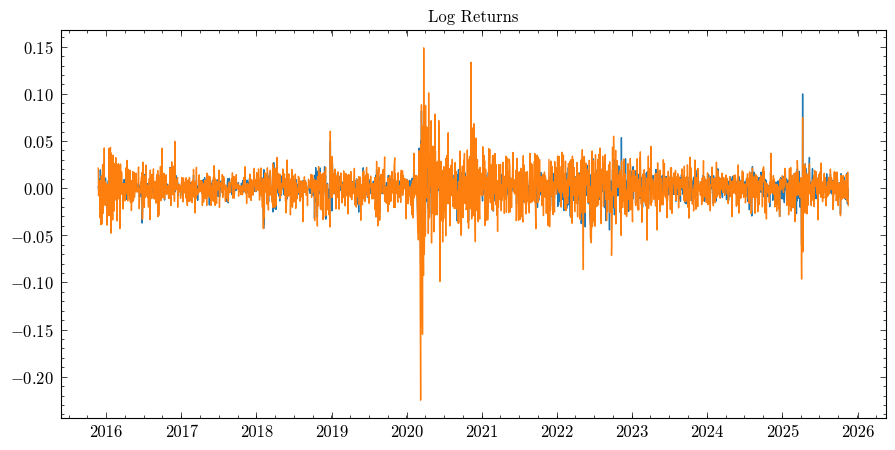

In [148]:
plt.figure(figsize=(10,5))
plt.title('Log Returns')
plt.plot(df['DATE'], df['SPY_r'])
plt.plot(df['DATE'], df['XLE_r'])

idiosyncratic volatility of XLE

In [149]:
X = df[['SPY_r']]   #
y = df['XLE_r']     

model = LinearRegression()
model.fit(X, y)


df['XLE_idio'] = y - model.predict(X)

In [220]:
df['XLE_idio_vol'] = transforms.realized_vol(df['XLE_idio'])

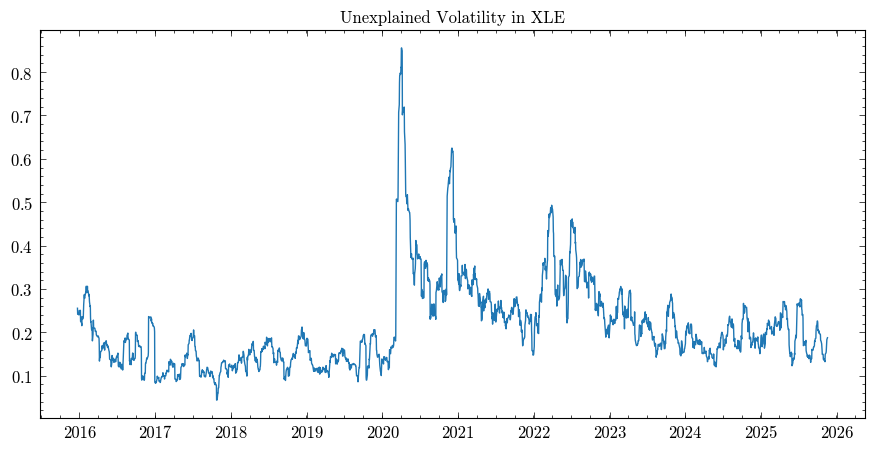

In [221]:
plt.figure(figsize=(10,5))
plt.title('Unexplained Volatility in XLE')
plt.plot(df['DATE'], df['XLE_idio_vol'] )

## Feature Selection

## Model Evaluation

In [222]:
analysis = df.dropna()

In [226]:
X = analysis[macro]
y = analysis['XLE_idio']    # garch input
y_vol = analysis['XLE_idio_vol'] # true target


In [227]:
stationary = transforms.enforce_stationarity(X)

In [228]:
stationary

,VIXCLS_d0,EFFR_d1,DGS2_d1,DGS10_d1,TEDRATE_d0,DCOILWTICO_d1,DHHNGSP_d0,DEXUSEU_d1
21,15.57,0.00,0.00,0.00,0.40,0.00,1.63,0.0000
22,15.74,0.00,0.02,-0.02,0.40,0.86,1.63,0.0080
23,16.91,0.00,0.02,-0.01,0.40,-1.26,2.11,0.0028
24,16.08,0.00,0.04,0.08,0.38,1.52,2.39,-0.0067
25,17.29,-0.01,-0.01,-0.01,0.40,-1.29,2.28,-0.0004
...,...,...,...,...,...,...,...,...
2506,17.28,0.00,0.00,0.00,0.09,0.00,3.80,0.0000
2507,17.51,0.00,-0.02,-0.05,0.09,0.00,3.80,0.0047
2508,20.00,0.01,0.02,0.03,0.09,0.00,3.80,0.0057
2509,19.83,0.00,0.04,0.03,0.09,0.00,3.80,-0.0032


In [229]:
results_garch = rolling_forecast_backtest(
    model_cls=GARCHRegressor,
    model_params={'returns': y, 'p': 1, 'q': 1},
    y=y_vol, 
    X=X
)

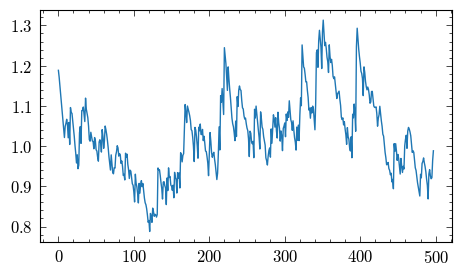

In [230]:
plt.plot(results_garch['y_pred'] - results_garch['y_true'])

In [231]:
results = evaluate_performance(results_garch)

In [232]:
results

{'rmle': np.float64(1.0316094043663535),
 'qlike': np.float64(2.782272349376869)}

In [233]:
y_vol

21      0.255273
22      0.241308
23      0.244412
24      0.244067
25      0.239689
          ...   
2506    0.155714
2507    0.165387
2508    0.176990
2509    0.182861
2510    0.187253
Name: XLE_idio_vol, Length: 2490, dtype: float64

In [234]:
results_xgb = rolling_forecast_backtest(
    model_cls=XGBRVModel,
    model_params={"max_depth": 3, "n_estimators": 300},
    y=y_vol,
    X=X
)

In [235]:
results = evaluate_performance(results_xgb)

In [236]:
results

{'rmle': np.float64(0.02532861078074276),
 'qlike': np.float64(0.03461837138126878)}

In [249]:
results_arima = rolling_forecast_backtest(
    model_cls=ARIMA_RV_Model,
    model_params={'order': (1,0,0)},
    y=y_vol,
    X=None
)

In [250]:
results = evaluate_performance(results_arima)

In [251]:
results

{'rmle': np.float64(0.010066313596619839),
 'qlike': np.float64(0.00580860503365017)}

### Testing